# Denoising medical images using Dilated convolutional neural network

In this notebook, we will denoise images from the MIAS database previously studied in the detection TD.

# Imports

In [0]:
import torch
import torchvision as tv
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import time
import numpy as np
from PIL import Image
from tqdm import tqdm
from glob import glob
import imageio
import matplotlib.pyplot as plt
from skimage.transform import resize

# Part 1: The MIAS database

The MIAS database comprises medical images of breasts with and without tumours. The images are two dimensional 

## a. Download database and create train, validation and test set

In [0]:
%%shell
mkdir mias-db && cd mias-db
wget http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz
tar -zxvf all-mias.tar.gz
rm all-mias.tar.gz && cd ..

--2020-02-21 12:04:15--  http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz
Resolving peipa.essex.ac.uk (peipa.essex.ac.uk)... 155.245.93.3
Connecting to peipa.essex.ac.uk (peipa.essex.ac.uk)|155.245.93.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111154265 (106M) [application/gzip]
Saving to: ‘all-mias.tar.gz’

all-mias.tar.gz     100%[===================>] 106.00M  11.3MB/s    in 10s     

2020-02-21 12:04:26 (10.4 MB/s) - ‘all-mias.tar.gz’ saved [111154265/111154265]

Info.txt
Licence.txt
README
mdb001.pgm
mdb002.pgm
mdb003.pgm
mdb004.pgm
mdb005.pgm
mdb006.pgm
mdb007.pgm
mdb008.pgm
mdb009.pgm
mdb010.pgm
mdb011.pgm
mdb012.pgm
mdb013.pgm
mdb014.pgm
mdb015.pgm
mdb016.pgm
mdb017.pgm
mdb018.pgm
mdb019.pgm
mdb020.pgm
mdb021.pgm
mdb022.pgm
mdb023.pgm
mdb024.pgm
mdb025.pgm
mdb026.pgm
mdb027.pgm
mdb028.pgm
mdb029.pgm
mdb030.pgm
mdb031.pgm
mdb032.pgm
mdb033.pgm
mdb034.pgm
mdb035.pgm
mdb036.pgm
mdb037.pgm
mdb038.pgm
mdb039.pgm
mdb040.pgm
mdb041.pgm
mdb042.pgm
mdb04

In [0]:
# Path to database
mias_db_path = './mias-db/'
info_file = 'Info.txt'
# Some cases contain abnormalities so we will exclude them.
to_exclude = ('mdb216', 'mdb233', 'mdb245', 'mdb059')

# Images to include in the validation set
val_set = ('mdb001', 'mdb002', 'mdb005', 'mdb010', 'mdb012', 'mdb013')
# Images to include in the test set
test_set = ('mdb090', 'mdb091', 'mdb121', 'mdb134', 'mdb145', 'mdb218')

# Read the info (class and bounding box) for each image
with open(os.path.join(mias_db_path, info_file), 'r') as fp:
    info = [f.strip() for f in fp.readlines() if f.startswith('mdb') and not f.startswith(to_exclude) 
    and not f.startswith(test_set)
    and not f.startswith(val_set)]
with open(os.path.join(mias_db_path, info_file), 'r') as fp:    
    test_info = [f.strip() for f in fp.readlines() if f.startswith(test_set)]
with open(os.path.join(mias_db_path, info_file), 'r') as fp:
    val_info = [f.strip() for f in fp.readlines() if f.startswith(val_set)]

In [0]:
# Make lists of the images' paths for the train, validation and test sets
# and analog lists to store the images' classes.
img_list = [os.path.join(mias_db_path, f.split(' ')[0] + '.pgm') for f in info]
val_img_list = [os.path.join(mias_db_path, f.split(' ')[0] + '.pgm') for f in val_info]
test_img_list = [os.path.join(mias_db_path, f.split(' ')[0] + '.pgm') for f in test_info]

In [0]:
# Compute dataset mean and standard deviation to later standardize dataset
def compute_dataset_stats(img_list):       
    X = np.array([imageio.imread(img_path).astype(np.uint8) for img_path in img_list])
    return X.mean(), X.std()

mu, var = compute_dataset_stats(img_list)
print("Dataset:     mean =  {:.2f}  - std =  {:.2f}".format(mu, var))

Dataset:     mean =  54.32  - std =  74.33


## b. Create the dataset class

In the dataset class, we need to create the noisy images to denoise. To do that, we need to add noise (gaussian for example) to the original image.


In the `__getitem__` function:

- standardize the image using the mean and standard deviation computed over the training set.
- downsample the image by 8 to speed up the training.
- create the noisy image.

In [0]:
class NoisyDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_list, data_augmentation_factor, mu, var, transforms=True, only_noise=False, name="train"):
        """
        Arguments:
            - img_list: list of the images paths
            - data_augmentation_factor: int - number of times an image is augmented. Set
            it to 0 if no augmentation is wanted.
            - mu: mean of the training set - used for standardization
            - var: standard deviation of the training set - used for standardization
            - transforms: bool - indicates whether to apply data augmentation 
            - name: string - name of the dataset (train, validation or test)
            - only_noise: bool - whether or not to do residual learning
        """
        np.random.seed(0)
                
        if not data_augmentation_factor: self.data_augmentation_factor = 1
        else: self.data_augmentation_factor = data_augmentation_factor
        self.img_list = img_list
        self.transforms = transforms
        self.only_noise = only_noise
        self.name = name        
        self.mean = mu
        self.std = var

        # Create dictionary that maps each image to some specific noise and the
        # image's path
        dicts = []
        for image_path in img_list:
            for _ in range(self.data_augmentation_factor):

                # Define noise to be applied
                p = np.random.rand()
                if p < 0.5: noise_type = "gaussian"
                else: noise_type ="speckle"

                # Add image-noise pair information to the info dictionary
                dicts.append({'path': image_path,
                              'noise': noise_type})            
        self.img_dict = {image_id: info for image_id, info in enumerate(dicts)}


    def __getitem__(self, image_id):
        np.random.seed(0)

        #load image
        img = imageio.imread(self.img_dict[image_id]['path']).astype(np.uint8)
        #standardize it
        ''' Complete here '''
        #downsample the images' size (to speed up training)
        ''' Complete here '''

        #create noisy image 
        noise_type = self.img_dict[image_id]['noise']       
        if noise_type == "gaussian":
            noise = ''' Complete here '''
        elif noise_type == "speckle":  
            noise =  ''' Complete here '''            
        noisy_img = img + noise

        #if residual learning, ground-truth should be the noise
        if self.only_noise: img = noise

        #convert to PIL images
        img = Image.fromarray(img)
        noisy_img = Image.fromarray(noisy_img)

        #apply the same data augmentation transformations to the input and the 
        #ground-truth
        p = np.random.rand()
        if self.transforms and p<0.5: 
            self.t = T.Compose([T.RandomHorizontalFlip(1), T.ToTensor()])
        else: self.t = T.Compose([T.ToTensor()])
        img = self.t(img)
        noisy_img = self.t(noisy_img)
        return noisy_img, img

    def __len__(self):
        return len(self.img_dict)

torch.Size([1, 128, 128])
Noise : gaussian


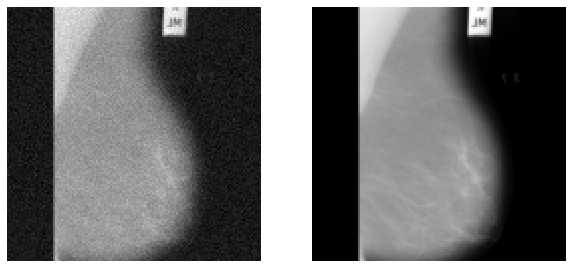

In [0]:
#display a noisy image and its denoised ground-truth
idx = 2

train = NoisyDataset(img_list, 0, mu, var, True)
x, y = train[idx]
print(x.shape)
print("Noise : {}".format(train.img_dict[idx]['noise']))

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(x[0], cmap="gray")
plt.axis('off')
plt.subplot(122)
plt.imshow(y[0], cmap="gray")
plt.axis('off')
plt.show()

# Part 2: Create the model

## a. Define the model's architecture

We will used a neural network inspired by https://arxiv.org/pdf/1708.05473.pdf which makes use of dilated convolutional layers (https://towardsdatascience.com/review-dilated-convolution-semantic-segmentation-9d5a5bd768f5)


### **About the architecture**

- The size of each layer's output should be the same as the size of the input.
- The first and last layers should be regular convolutions with ReLU activations.
- In between the first and last convolutions you should have several "DilatedConv-BatchNorm-ReLU" blocks.



In [0]:
class DilatedCNN(nn.Module):
  def __init__(self):
    super(DilatedCNN,self).__init__()
    self.convlayers = nn.Sequential(
      ''' Complete here '''
    )

  def forward(self,x):
    ''' Complete here '''
    return x

## b. Check your model

- Print the model's architecture.
- Check that the ouput is the same size as the input.

In [0]:
model = DilatedCNN()

#print model architecture
''' Complete here '''

#check that the model's output has the same size as the input image
''' Complete here '''
y = model(x)

print('Input size: {}'.format(x.shape))
print('Output size: {}'.format(y.shape))

## c. Compute the number of trainable parameters in your model

In [0]:
#compute the number of trainable parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of trainable parameters: {}".format(params))

Number of trainable parameters: 401157


# Part 3: Training the model

In this section, you have to:

- fill out the training loop `train_one_epoch` and the validation function `validate`
- define your own loss function in `my_loss_function`
- define the optimizer and its hyperparameters
- train your model

## a. Create the training loop

In [0]:
def train_one_epoch(model, data_loader, optimizer, loss_function, epoch, writer, device):
    #switch to training mode
    model.train()

    epoch_loss = 0
    for i, data in tqdm(enumerate(data_loader, 1)):

        #get inputs and ground-truth from batch data
        ''' Complete here '''

        #put the data on gpu
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        #clear old gradients
        ''' Complete here '''

        #forward to predict
        ''' Complete here '''

        #backward prop
        #compute loss
        ''' Complete here '''

        #compute gradients
        ''' Complete here '''

        #parameters update
        ''' Complete here '''

        #add batch loss to epoch loss
        batch_size = len(inputs)
        epoch_loss += loss.item()
        #update loss in tensorboard
        writer.add_scalar("Training Loss", loss.item(), epoch*len(data_loader)+i)

    #compute overall loss for the epoch
    epoch_loss /= i    
    return epoch_loss


def validate(model, val_data_loader, loss_function, epoch, writer, device, only_noise):
    #switch to inference mode
    model.eval()

    val_loss = 0
    figures = []
    for i, data in enumerate(val_data_loader, 1):

        #get batch data
        ''' Complete here '''

        #put the data on gpu
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)
        
        #inference
        ''' Complete here '''

        #compute loss
        ''' Complete here '''

        #aggregate batch loss
        batch_size = len(inputs)
        val_loss += loss.item()

    #get the figures to compare predictions vs ground-truth
    figures += plot_prediction(inputs[:1], outputs[:1], ground_truth[:1], only_noise, plot=True)

    #compute normalized loss of the epoch
    val_loss /= i

    #update tensorboard
    writer.add_figure("Prediction vs Ground-truth", plot_prediction(inputs, outputs, ground_truth, only_noise), epoch)
    writer.add_scalar("Validation Loss", val_loss, epoch)
    return val_loss, figures

In [0]:
def evaluate(model, data_loader):
    #switch to inference mode
    model.eval()

    #evaluate model on test set and plot the predictions
    test_loss = 0
    figures = []
    for i, data in enumerate(test_data_loader, 1):
        #get batch data
        ''' Complete here '''

        #move data to gpu
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        #inference
        ''' Complete here '''

        #compute loss
        ''' Complete here '''
        
        #aggregate batch loss
        test_loss += loss.item()
        #prediction vs ground-truth figures
        figures += plot_prediction(inputs, outputs, ground_truth, only_noise=False, plot=True)

    print("Loss over test set: {:.2f}".format(test_loss/i))  

In [0]:
#function for tensorboard to display predictions and ground-truth images
def plot_prediction(inputs, outputs, ground_truth, only_noise, plot=False):
    figures = []    
    for i in range(len(inputs)):
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax1.set_title("Noisy image")
        ax2.set_title("Denoised image")
        ax3.set_title("Ground-truth")       

        if only_noise:
            ax1.imshow(inputs[i, 0].detach().cpu(), cmap='gray')
            ax2.imshow(inputs[i, 0].detach().cpu() - outputs[i, 0].detach().cpu(), cmap='gray')
            ax3.imshow(inputs[i, 0].detach().cpu() - ground_truth[i, 0].detach().cpu(), cmap='gray')
        else:
            ax1.imshow(inputs[i, 0].detach().cpu(), cmap='gray')
            ax2.imshow(outputs[i, 0].detach().cpu(), cmap='gray')
            ax3.imshow(ground_truth[i, 0].detach().cpu(), cmap='gray')
        if plot: plt.show()
        figures.append(fig)
    return figures

## b. Create the data loaders

We will first train the model to do regular denoising (`only_noise = False`)

Try residual denoising (`only_noise = True`) afterwards.

In [0]:
# Parameters indicating whether to do residual learning
# only_noise=True --> Residual learning
only_noise = False

train = NoisyDataset(img_list, 3, mu, var, True, only_noise, name="train")
val = NoisyDataset(val_img_list, 0, mu, var, False, only_noise, name="validation")
test = NoisyDataset(test_img_list, 0, mu, var, False, only_noise, name="test")

print("\nNumber of images in training set: {}".format(len(train)))
print("Number of images in validation set: {}".format(len(val)))
print("Number of images in test set: {}".format(len(test)))


Number of images in training set: 939
Number of images in validation set: 7
Number of images in test set: 6


In [0]:
# Data loaders for train, validation and test sets
torch.manual_seed(1)

data_loader = torch.utils.data.DataLoader(
    train, batch_size=32, shuffle=True, num_workers=8)

val_data_loader = torch.utils.data.DataLoader(
    val, batch_size=4, shuffle=False, num_workers=8)

test_data_loader = torch.utils.data.DataLoader(
    test, batch_size=4, shuffle=False, num_workers=8)

## c. Define your own loss function and choose the optimizer

- Define the loss function. You should implement the Mean Square Error and the L1-loss. What differences do you observe in the results when training with one or the other (or both) ?
- Choose the optimizer and the hyperparameters.


In [0]:
# Define your own loss function
def my_loss_function(output, target):
    ''' Complete here '''

In [0]:
#instantiate the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DilatedCNN()
model.to(device) # move model to the right device

cuda
DilatedCNN(
  (convlayers): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), d

In [0]:
loss_function = my_loss_function

#choose the optimizer
optimizer = ''' Complete here '''

## d. Train your neural network

In [0]:
#instantiate tensorboard writer
if './logs' in glob("./*"):  
    !rm -r logs
log_dir = 'logs/'
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = torch.utils.tensorboard.SummaryWriter(log_dir)

30it [01:51,  2.77s/it]


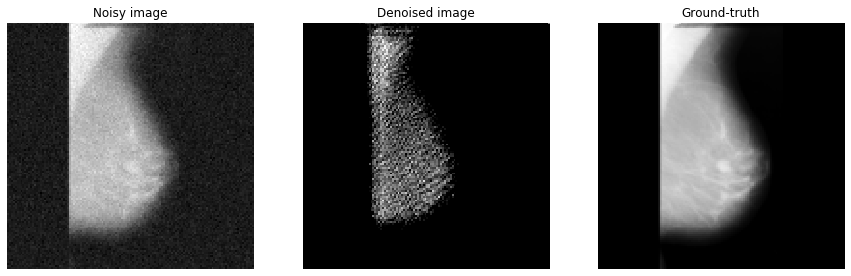

Epoch 0  (time: 1.89 min):    loss: 1.1895   --   val_loss: 0.1127


30it [01:56,  2.82s/it]


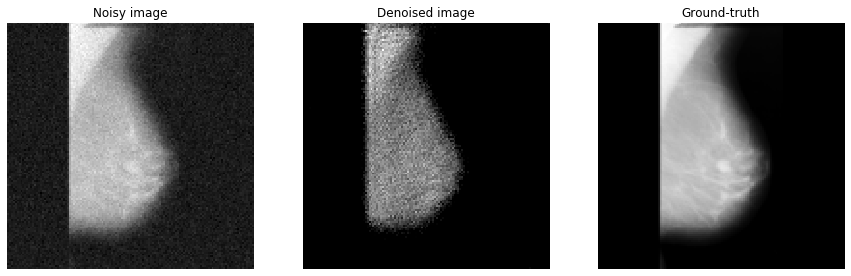

Epoch 1  (time: 1.96 min):    loss: 0.9023   --   val_loss: 0.0591


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DilatedCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
30it [01:57,  2.83s/it]


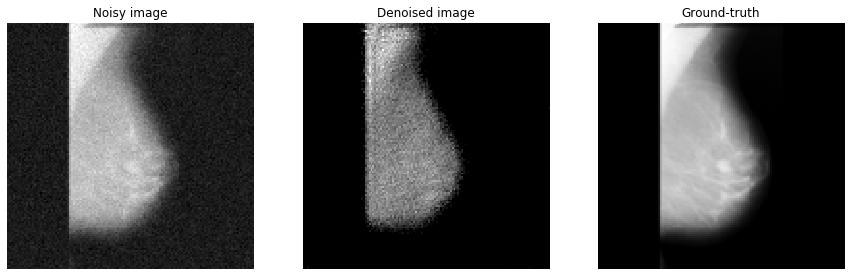

Epoch 2  (time: 1.98 min):    loss: 0.8689   --   val_loss: 0.0588


30it [01:55,  2.83s/it]


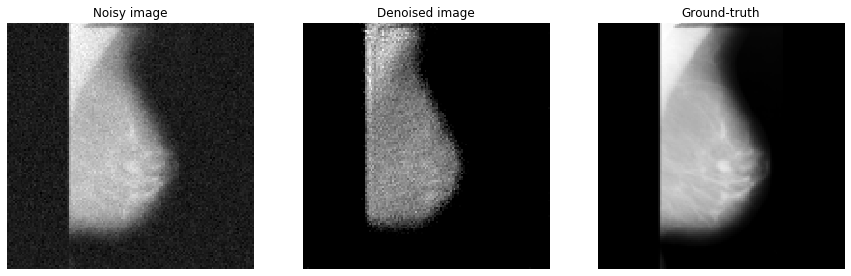

Epoch 3  (time: 1.98 min):    loss: 0.8573   --   val_loss: 0.0562


30it [01:57,  2.84s/it]


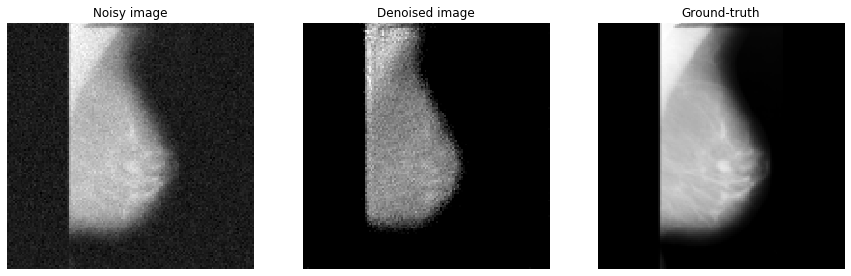

Epoch 4  (time: 1.98 min):    loss: 0.8427   --   val_loss: 0.0555


30it [01:57,  2.83s/it]


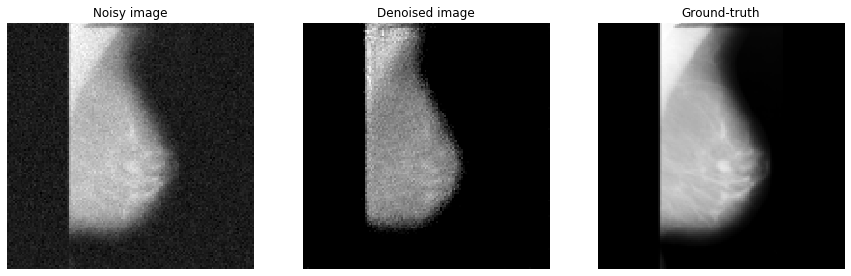

Epoch 5  (time: 1.98 min):    loss: 0.8361   --   val_loss: 0.0555


30it [01:56,  2.82s/it]


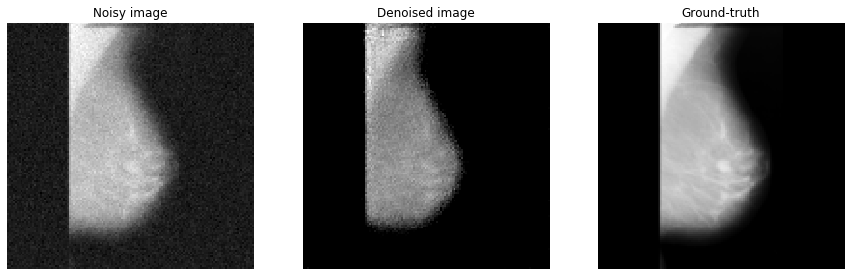

Epoch 6  (time: 1.98 min):    loss: 0.8297   --   val_loss: 0.0549


30it [01:57,  2.82s/it]


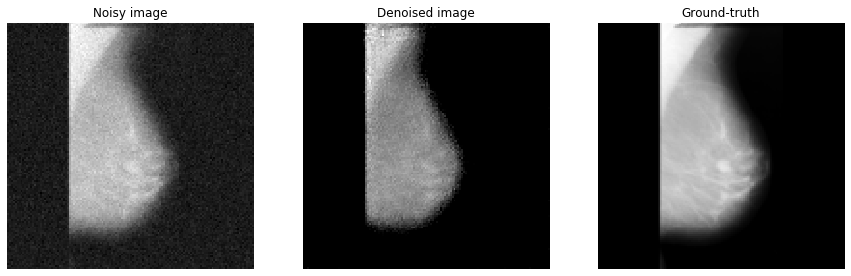

Epoch 7  (time: 1.98 min):    loss: 0.8222   --   val_loss: 0.0549


30it [01:55,  2.84s/it]


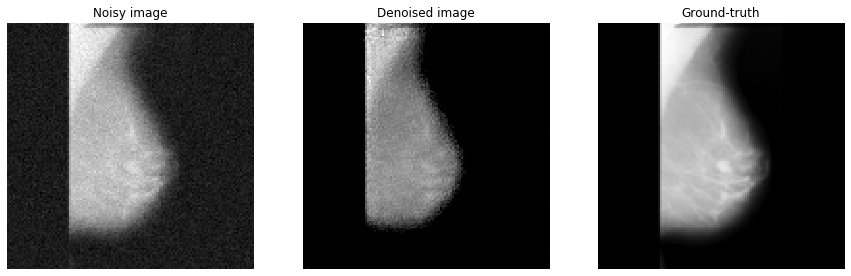

Epoch 8  (time: 1.98 min):    loss: 0.8137   --   val_loss: 0.0540


30it [01:57,  2.82s/it]


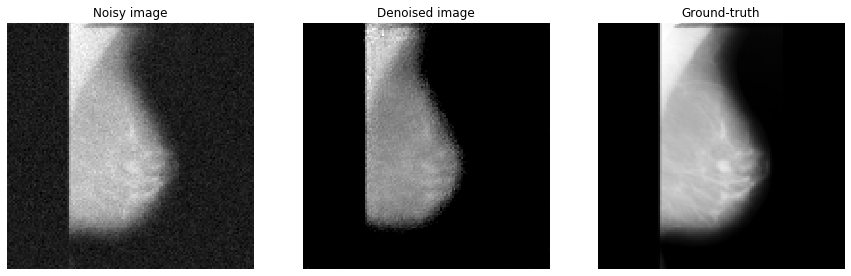

Epoch 9  (time: 1.98 min):    loss: 0.8164   --   val_loss: 0.0540


30it [01:56,  2.82s/it]


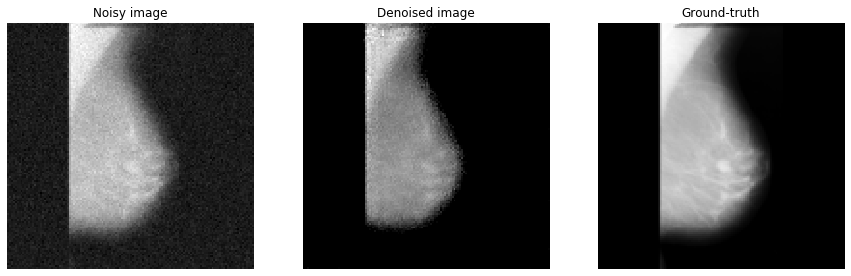

Epoch 10  (time: 1.97 min):    loss: 0.8123   --   val_loss: 0.0537


30it [01:56,  2.82s/it]


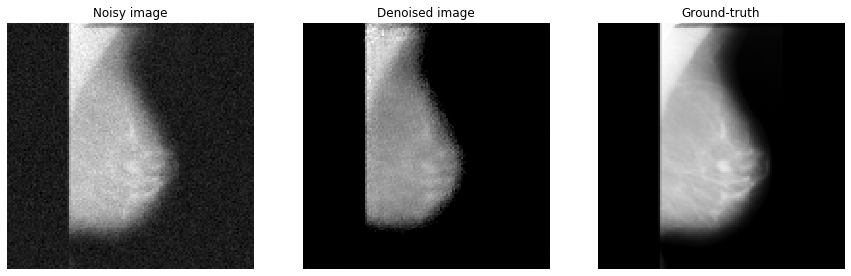

Epoch 11  (time: 1.97 min):    loss: 0.8101   --   val_loss: 0.0536


30it [01:56,  2.83s/it]


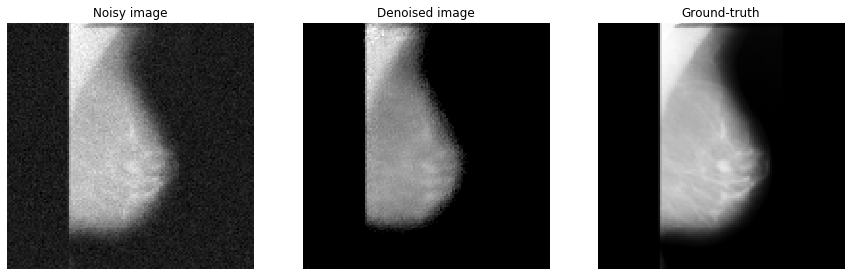

Epoch 12  (time: 1.97 min):    loss: 0.8082   --   val_loss: 0.0564


30it [01:59,  2.82s/it]


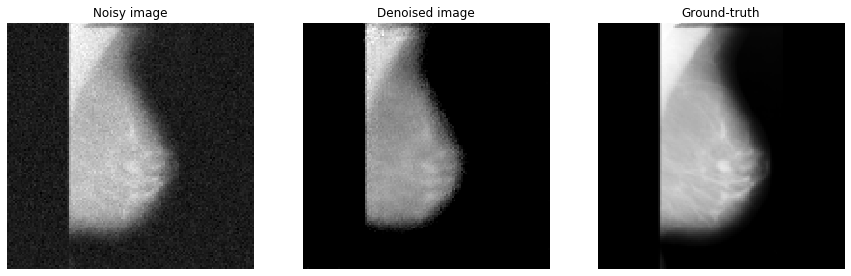

Epoch 13  (time: 2.02 min):    loss: 0.8121   --   val_loss: 0.0540


30it [01:56,  2.83s/it]


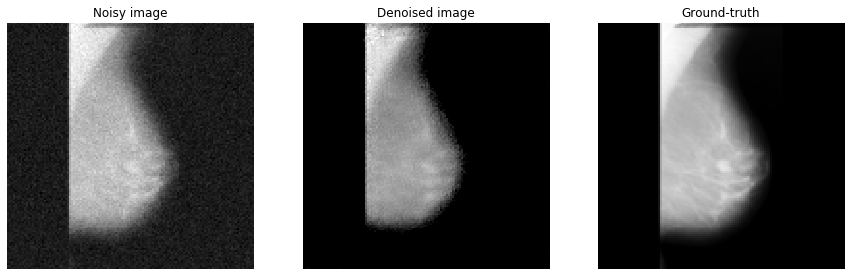

Epoch 14  (time: 1.97 min):    loss: 0.8026   --   val_loss: 0.0541


30it [01:56,  2.82s/it]


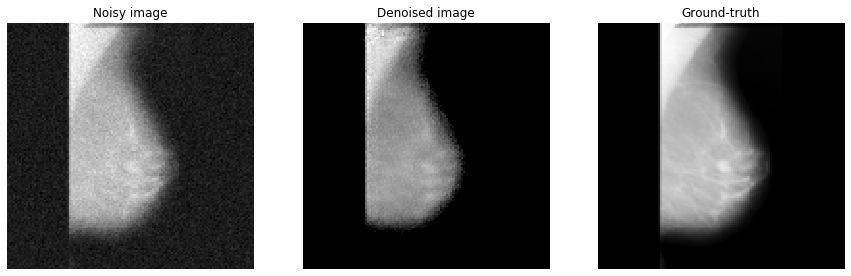

Epoch 15  (time: 1.97 min):    loss: 0.8006   --   val_loss: 0.0531


30it [01:56,  2.82s/it]


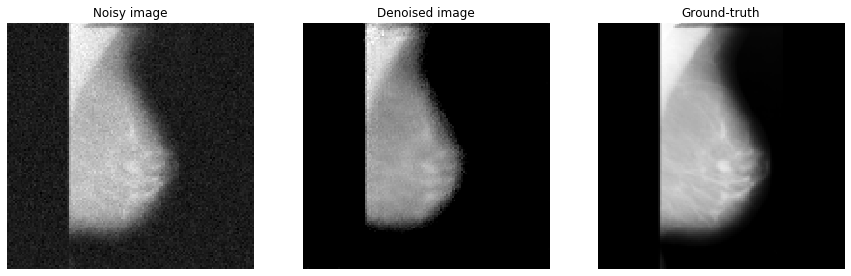

Epoch 16  (time: 1.96 min):    loss: 0.8006   --   val_loss: 0.0536


30it [01:57,  2.82s/it]


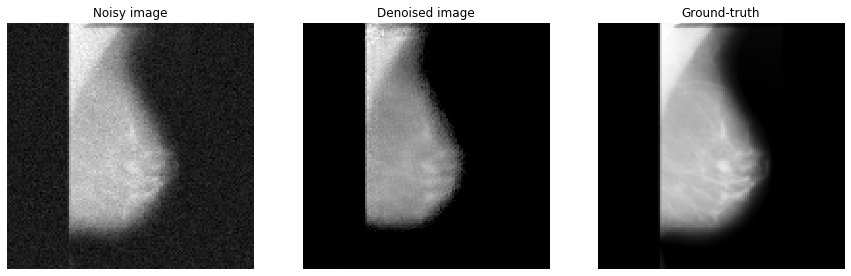

Epoch 17  (time: 1.98 min):    loss: 0.8046   --   val_loss: 0.0529


30it [01:55,  2.83s/it]


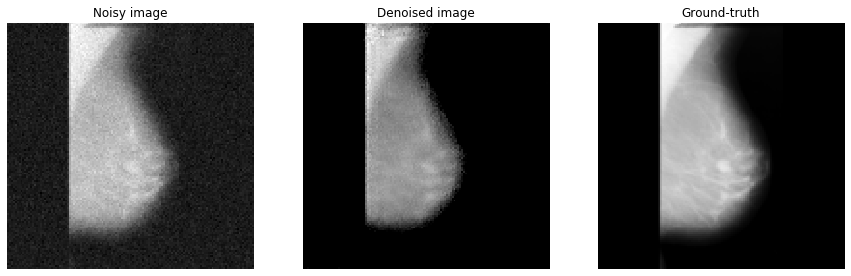

Epoch 18  (time: 1.98 min):    loss: 0.8010   --   val_loss: 0.0540


30it [01:56,  2.82s/it]


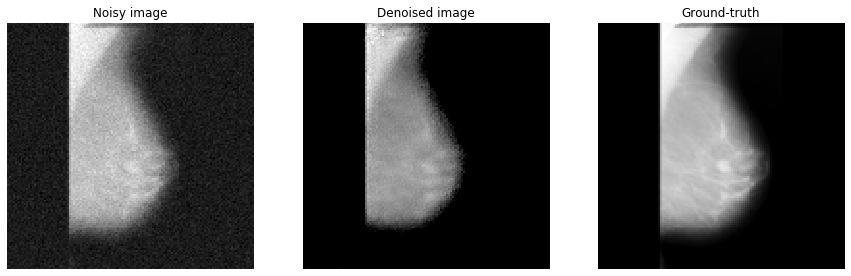

Epoch 19  (time: 1.96 min):    loss: 0.8012   --   val_loss: 0.0532
Overall training time: 39.45 minutes


In [0]:
#train the model
train_loss, val_loss = [], []
for epoch in range(20):
    start = time.time()

    #train for the epoch
    train_loss_ = train_one_epoch(model, data_loader, optimizer, loss_function, epoch, writer, device)

    #evaluate on validation set  
    val_loss_, figures_ = validate(model, val_data_loader, loss_function, epoch, writer, device, only_noise)

    print("Epoch {}  (time: {:.2f} min):    loss: {:.4f}   --   val_loss: {:.4f}".format(
        epoch, 
        (time.time()-start)/60, 
        train_loss_, 
        val_loss_))
    
    #uncomment next line to save the best performing model according to the validation loss
    # if epoch > 0 and val_loss_ < val_loss[-1]: torch.save(model, 'best_dilated_model.pt')

    #store the losses computed over the epoch
    train_loss += [train_loss_]
    val_loss += [val_loss_]

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir '/content/logs/'

In [0]:
#plot learning curves
plt.figure(figsize=(7, 7))
plt.title("Learning curves")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()
plt.show()

# Part 4: Inference time

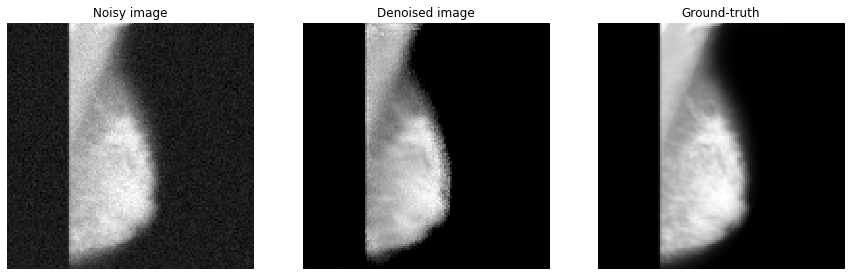

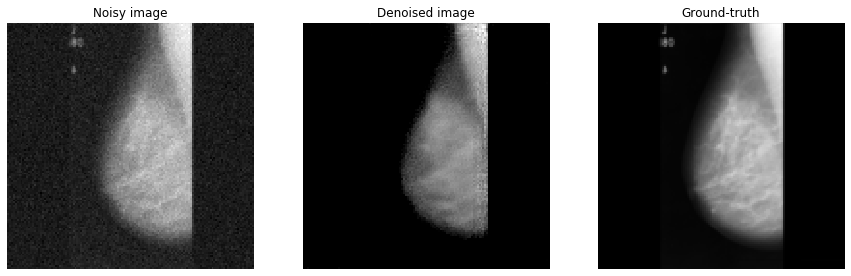

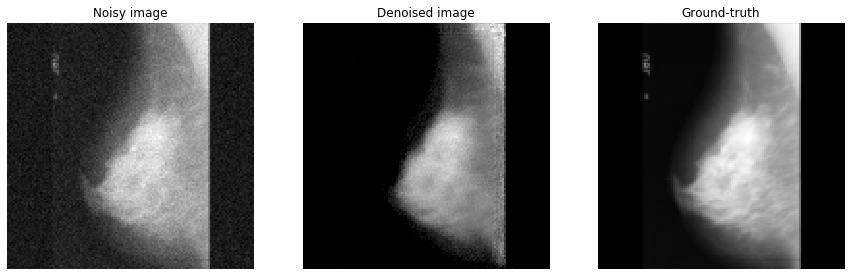

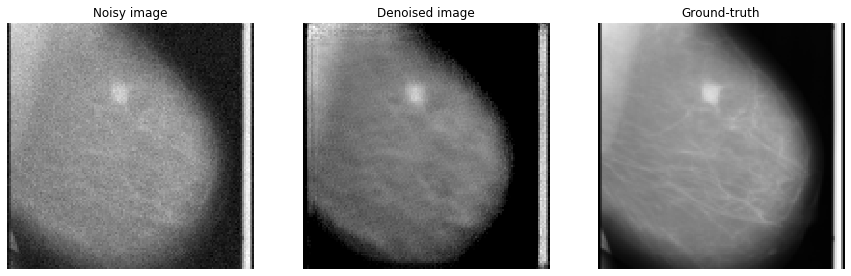

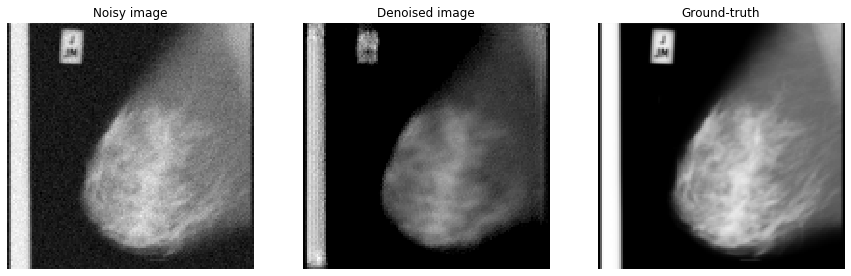

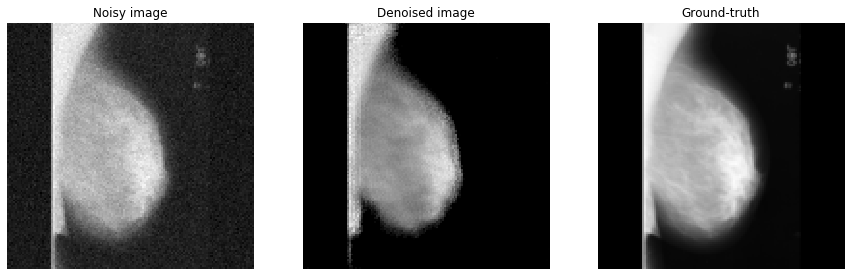

Loss over test set: 0.69


In [0]:
evaluate(model, test_data_loader)

# Part 5: Compare with UNET

## a. UNet architecture

In [0]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, skip=True, bilinear=True):
        super().__init__()
        self.skip = skip

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        if self.skip:
        # input is CHW
            diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
            diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
        
            x = torch.cat([x2, x1], dim=1)
        else: x = x1
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 128)
        self.up1 = Up(256, 64, skip=True, bilinear=bilinear)
        self.up2 = Up(128, 32, skip=True, bilinear=bilinear)
        self.up3 = Up(64, 16, skip=True, bilinear=bilinear)
        self.up4 = Up(16, 16, skip=False, bilinear=bilinear)
        self.outc = OutConv(16, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


## b. Define loss function and optimizer

In [0]:
#instantiate the model
unet = UNet(n_channels=1)

#print the model architecture
print(unet)

#check that the model's output has the same size as the input image
x, _ = train[0]
print(unet.forward(x.reshape(1, 1, x.shape[1], x.shape[1])).size()) 

#move model to gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
unet.to(device)

#compute the number of trainable parameters in the model
model_parameters = filter(lambda p: p.requires_grad, unet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of trainable parameters: {}".format(params))

#define optimizer and loss function
loss_function = my_loss_function
# loss_function = nn.MSELoss()
optimizer = optim.SGD(unet.parameters(), lr=0.001, momentum=0.5)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.

## c. Train UNet

30it [00:52,  1.76s/it]


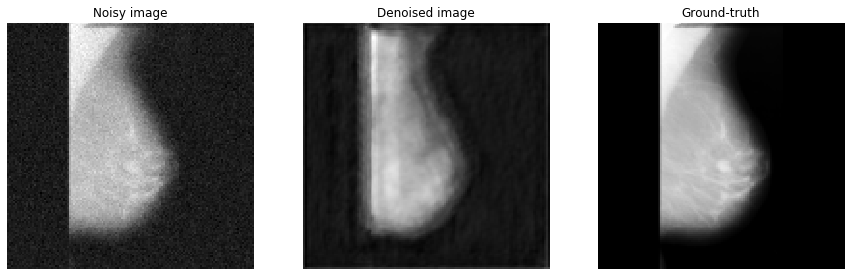

Epoch 0  (time: 0.91 min):    loss: 0.9418   --   val_loss: 0.0688


30it [00:53,  1.07s/it]


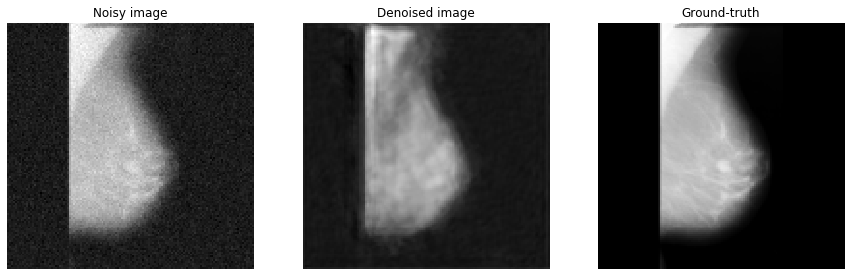

Epoch 1  (time: 0.91 min):    loss: 0.3264   --   val_loss: 0.0165


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DoubleConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Down. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Up. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packag

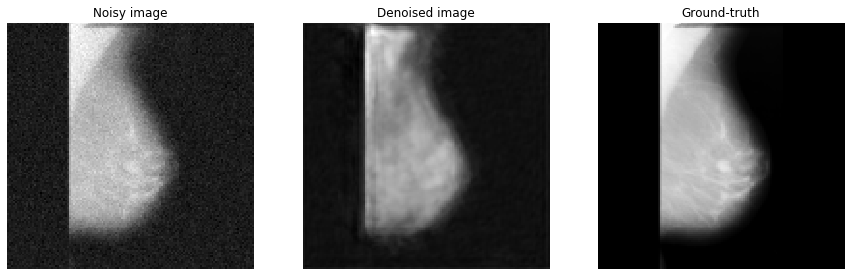

Epoch 2  (time: 0.90 min):    loss: 0.2010   --   val_loss: 0.0140


30it [00:52,  1.74s/it]


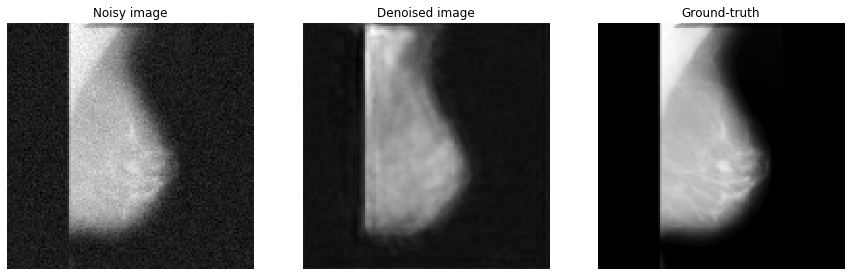

Epoch 3  (time: 0.90 min):    loss: 0.1594   --   val_loss: 0.0114


30it [00:53,  1.78s/it]


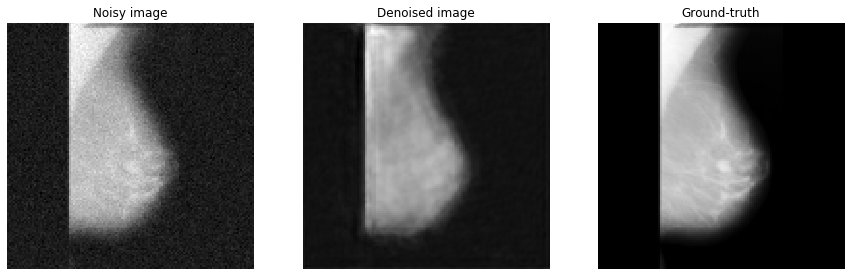

Epoch 4  (time: 0.91 min):    loss: 0.1376   --   val_loss: 0.0098


30it [00:53,  1.78s/it]


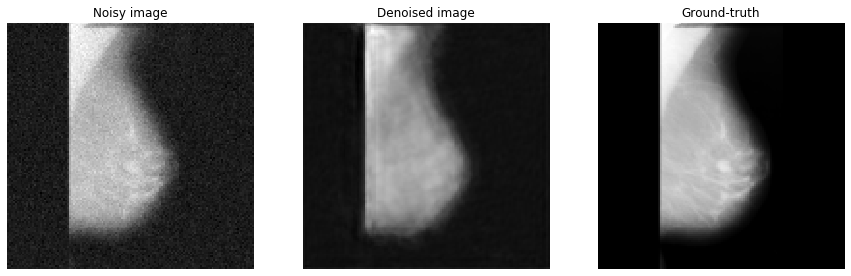

Epoch 5  (time: 0.92 min):    loss: 0.1270   --   val_loss: 0.0091


30it [00:53,  1.77s/it]


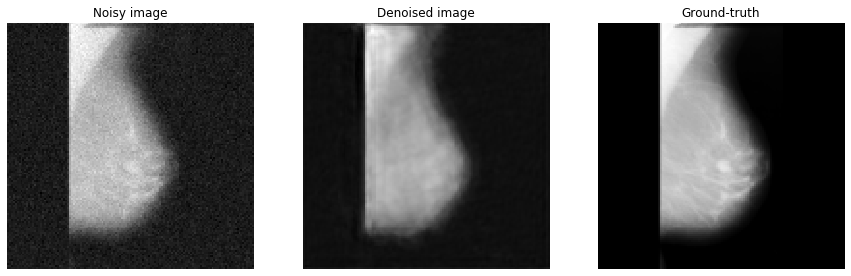

Epoch 6  (time: 0.91 min):    loss: 0.1219   --   val_loss: 0.0083


30it [00:52,  1.77s/it]


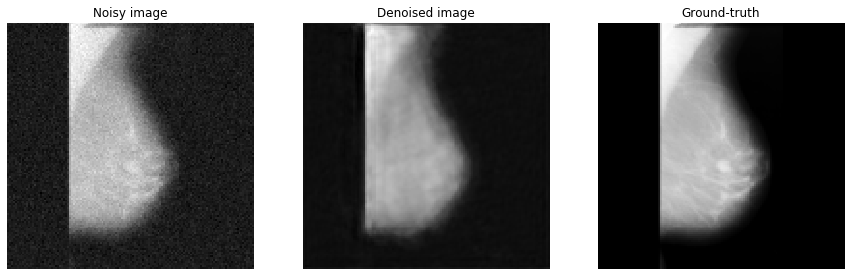

Epoch 7  (time: 0.91 min):    loss: 0.1089   --   val_loss: 0.0080


30it [00:53,  1.79s/it]


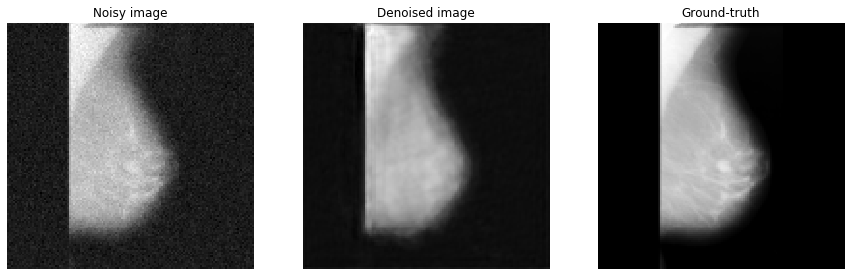

Epoch 8  (time: 0.92 min):    loss: 0.1048   --   val_loss: 0.0072


30it [00:54,  1.80s/it]


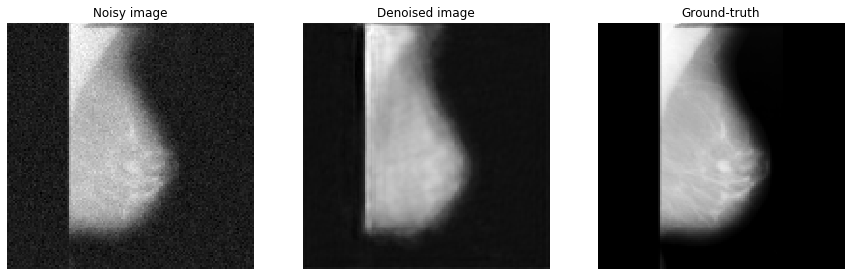

Epoch 9  (time: 0.93 min):    loss: 0.1016   --   val_loss: 0.0070


30it [00:52,  1.76s/it]


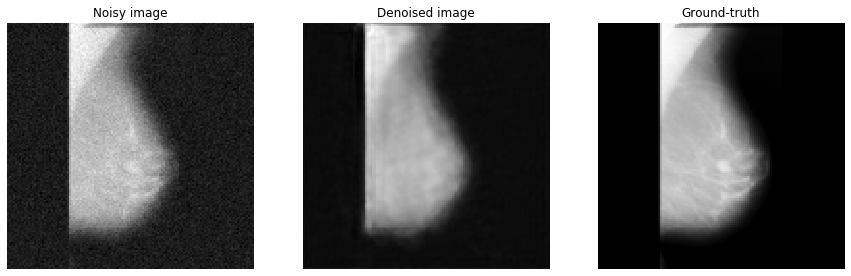

Epoch 10  (time: 0.91 min):    loss: 0.0937   --   val_loss: 0.0066


30it [00:53,  1.79s/it]


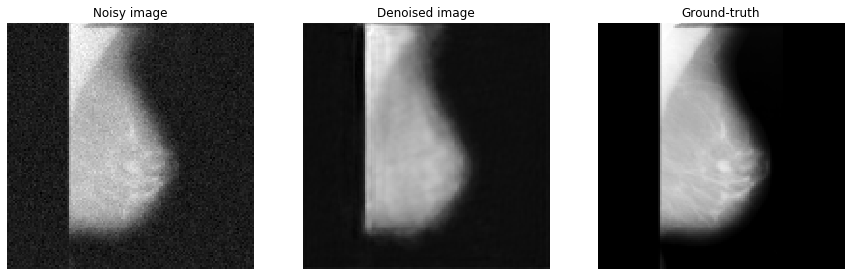

Epoch 11  (time: 0.92 min):    loss: 0.0943   --   val_loss: 0.0064


30it [00:52,  1.27it/s]


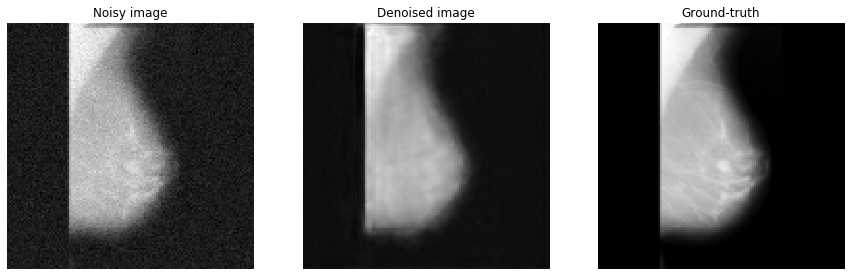

Epoch 12  (time: 0.91 min):    loss: 0.0872   --   val_loss: 0.0064


30it [00:53,  1.79s/it]


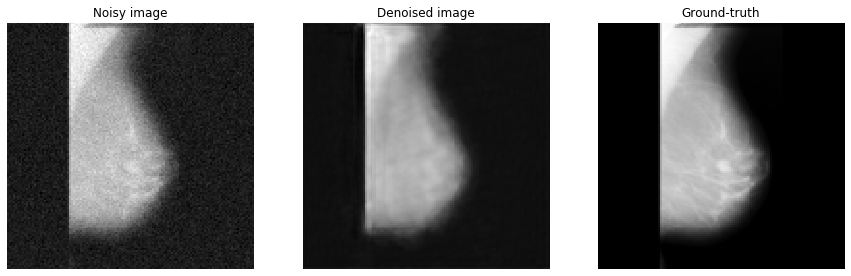

Epoch 13  (time: 0.92 min):    loss: 0.0842   --   val_loss: 0.0061


30it [00:53,  1.80s/it]


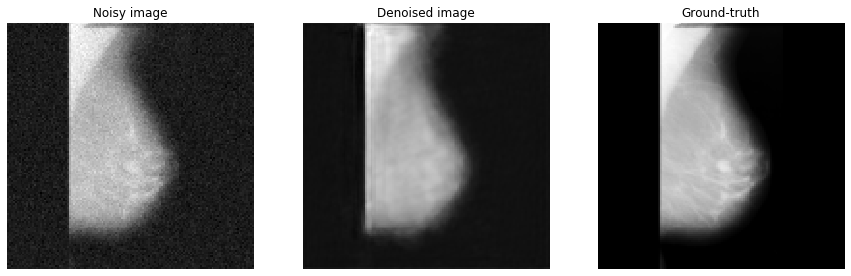

Epoch 14  (time: 0.92 min):    loss: 0.0931   --   val_loss: 0.0059


30it [00:53,  1.77s/it]


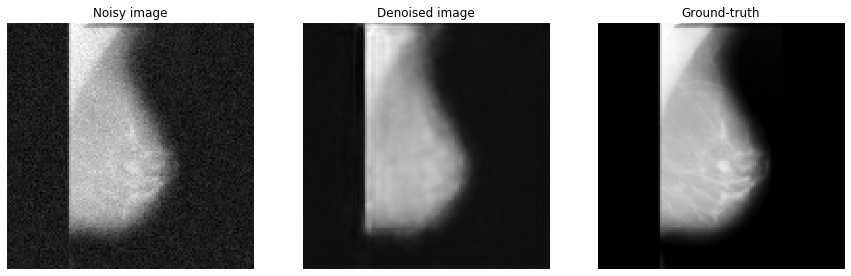

Epoch 15  (time: 0.92 min):    loss: 0.0829   --   val_loss: 0.0060


30it [00:52,  1.76s/it]


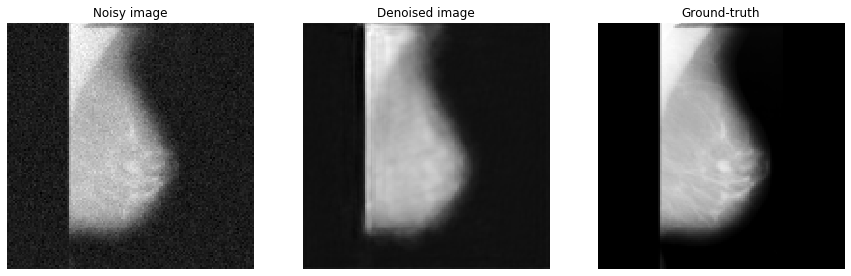

Epoch 16  (time: 0.90 min):    loss: 0.0825   --   val_loss: 0.0055


30it [00:53,  1.05s/it]


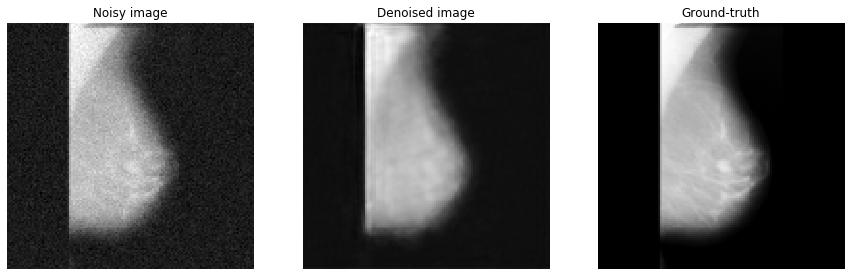

Epoch 17  (time: 0.91 min):    loss: 0.0857   --   val_loss: 0.0053


30it [00:53,  1.79s/it]


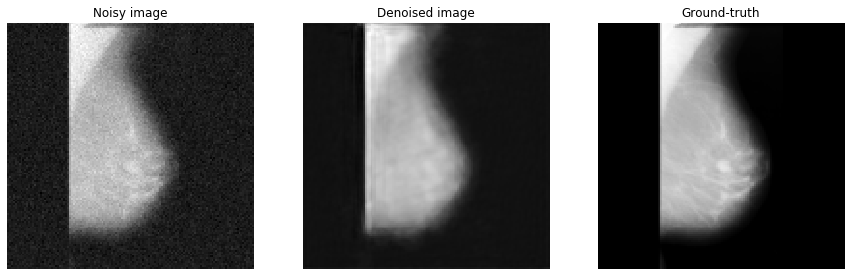

Epoch 18  (time: 0.92 min):    loss: 0.0770   --   val_loss: 0.0053


30it [00:53,  1.78s/it]


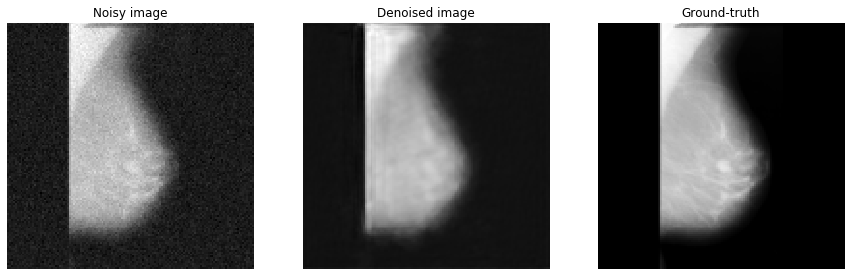

Epoch 19  (time: 0.91 min):    loss: 0.0815   --   val_loss: 0.0052


In [0]:
#instantiate tensorboard writer
writer = SummaryWriter()
train_loss, val_loss = [], []
for epoch in range(20):
    start = time.time()

    #train for the epoch
    train_loss_ = train_one_epoch(unet, data_loader, optimizer, loss_function, epoch, writer, device)

    #evaluate on validation set  
    val_loss_, figures = validate(unet, val_data_loader, loss_function, epoch, writer, device, only_noise)
    
    print("Epoch {}  (time: {:.2f} min):    loss: {:.4f}   --   val_loss: {:.4f}".format(
        epoch, 
        (time.time()-start)/60, 
        train_loss_, 
        val_loss_))
    
    #save the best performing model with respect to the validation loss
    if epoch > 0 and val_loss_ < val_loss[-1]: torch.save(unet, 'best_unet_model.pt')

    #store the losses computed over the epoch
    train_loss += [train_loss_]
    val_loss += [val_loss_]


## d. Evaluate UNet

In [0]:
evaluate(unet, test_data_loader)